In [2]:
#@title
import torch
from torch import nn
import torch.nn.functional as Fn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm
from collections import Counter

In [3]:
#@title
np.random.seed(1292139)
torch.manual_seed(2894347)

In [4]:
#@title
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#@title
training_data = datasets.MNIST(
root="data",
train=True,
download=True,
transform=ToTensor()
)
test_data = datasets.MNIST(
root="data",
train=False,
download=True,
transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
#@title
validation_split = .2 #20% validation split
shuffle_dataset = True
random_seed= 42


train_idx, val_idx,_,_= train_test_split(range(len(training_data)),training_data.targets, test_size=0.2,train_size=0.8, shuffle=True, stratify=training_data.targets)
   
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

test_loader = DataLoader(test_data, batch_size=64,num_workers = 2)

train_loader = DataLoader(training_data, batch_size=64, 
                                           sampler=train_sampler,num_workers = 2)
val_loader = DataLoader(training_data, batch_size=64, sampler = valid_sampler, num_workers = 2)


x = training_data.data
y = training_data.targets.to(device)

x_train = x[train_idx].to(torch.float).to(device)
y_train = y[train_idx].to(device)

x_val = x[val_idx].to(torch.float).to(device)
y_val = y[val_idx].to(device)

x_test = test_data.data.to(torch.float).to(device)
y_test = test_data.targets.to(device)


In [7]:
#@title

lr = 1e-2
batch_size = 64
epochs = 15   


In [8]:
#@title
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3,padding=1)
    self.fc1   = nn.Linear(49*32, 500)
    self.fc2   = nn.Linear(500, 10)

    self.activ = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)

  def pool(self, x, kernel_size=2):
    out = Fn.max_pool2d(x, kernel_size, stride=2)
    return out

  def forward(self, x):
    out = self.activ(self.conv1(x))
    out = self.pool(out)
    out = self.activ(self.conv2(out))
    out = self.pool(out)
    out = out.reshape(out.size(0), -1)
    out = self.activ(self.fc1(out))
    out = self.fc2(out)
    #out = self.softmax(out)
    return out

In [9]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#@title
import os
os.chdir('/content/drive/MyDrive/EE5179/')

In [11]:
#@title
os.getcwd()

'/content/drive/MyDrive/EE5179'

In [12]:
model_loaded = torch.load('model.pth',map_location=torch.device('cpu'))

In [177]:
def sample_img(label):
  for i in range(len(training_data)):
    if training_data[i][1] == label:
      return training_data[i][0]


<h2> Weights visualisation </h2>

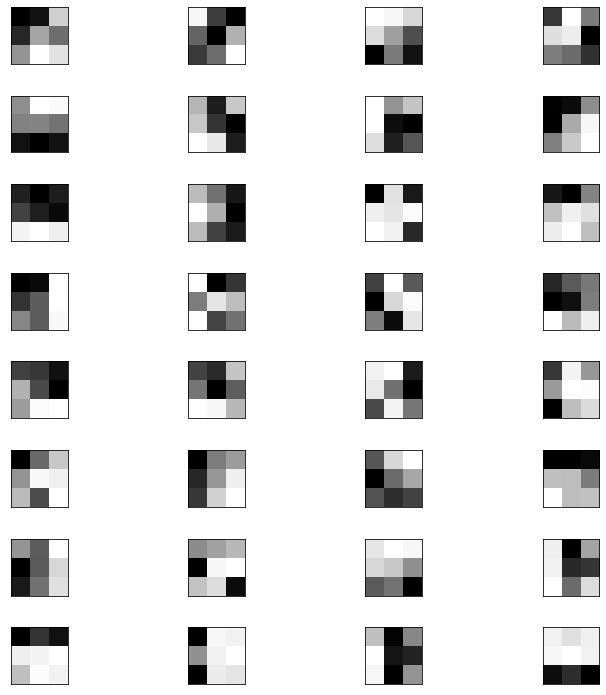

In [56]:
filter_weights = model_loaded.conv1.weight 
filters=filter_weights.cpu().data
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min) #normalised filters

ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for i in filters:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter_image=i.numpy()[0]
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

Note that we've normalised the filter weights to [0,1] range to make them amenable to plotting. So, the pixels in black or darker shade of grey mostly signify negative values.

We clearly don't have standard filters but some of them seem close matches to High-pass filters;the central pixel is white and the surrounding pixels are in shades of gray. While some others resemble horizontal or vertical edge detectors.

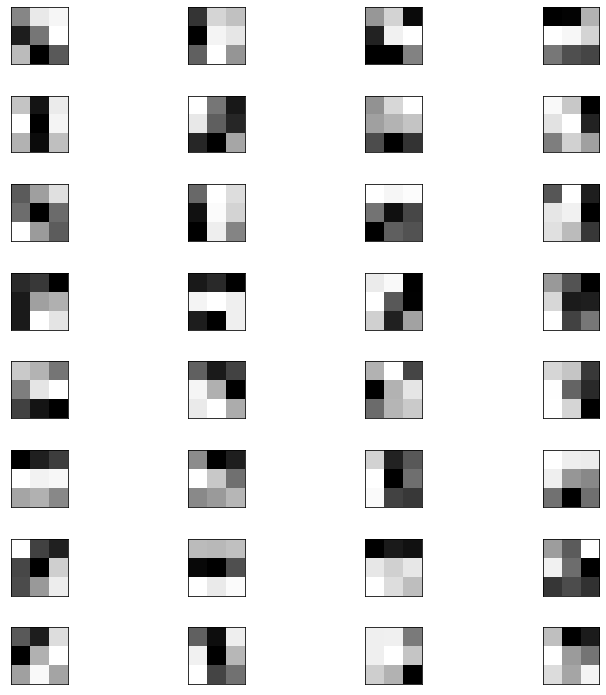

In [28]:
filter_weights = model_loaded.conv2.weight 
filters=filter_weights.cpu().data
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for i in filters:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter_image=np.mean(i.numpy(),axis=0)  #visualising the average across the depth
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

Note that the above is visualisation by taking average across the depth of the filters

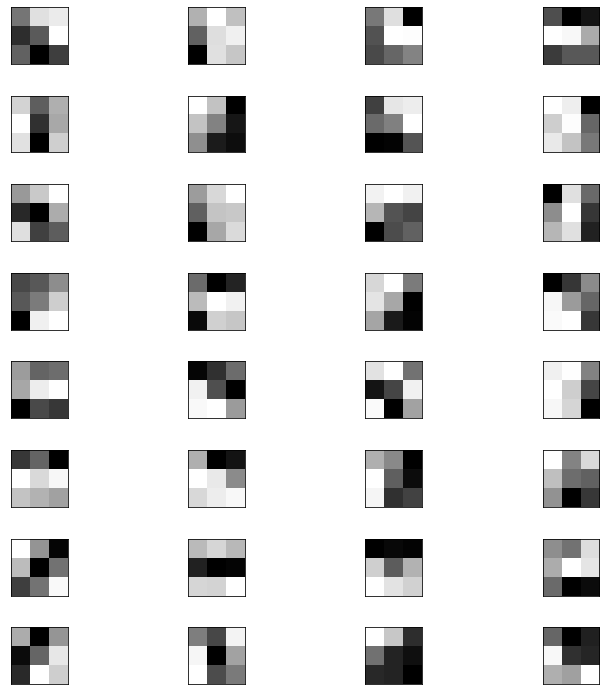

In [29]:
filter_weights = model_loaded.conv2.weight 
filters=filter_weights.cpu().data
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for i in filters:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter_image=i.numpy()[0]  #visualising the average across the depth
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

Clearly, most of the filters here are not so interpretable.

<h2> Feature-map visualisation </h2>

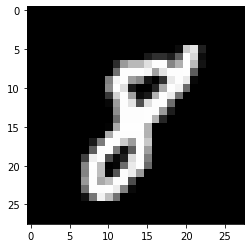

In [246]:
img = sample_img(8)
plt.imshow(img[0],cmap='gray')

Inputing the above image, lets visualise the feature maps

In [247]:
conv1,conv2 = list(model_loaded.children())[0],list(model_loaded.children())[1]

In [248]:
outputs = []

img = nn.ReLU()(conv1(img))
outputs.append(img)
img = Fn.max_pool2d(img, 2, stride=2)
img = nn.ReLU()(conv2(img))
outputs.append(img)

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

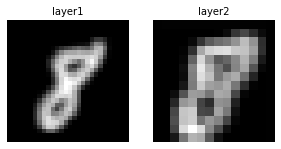

In [257]:
fig = plt.figure(figsize=(10, 16))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i],cmap='gray')
    a.axis("off")
    a.set_title(f'layer{i+1}', fontsize=10)



This is the image obtained by taking the average across all the channels

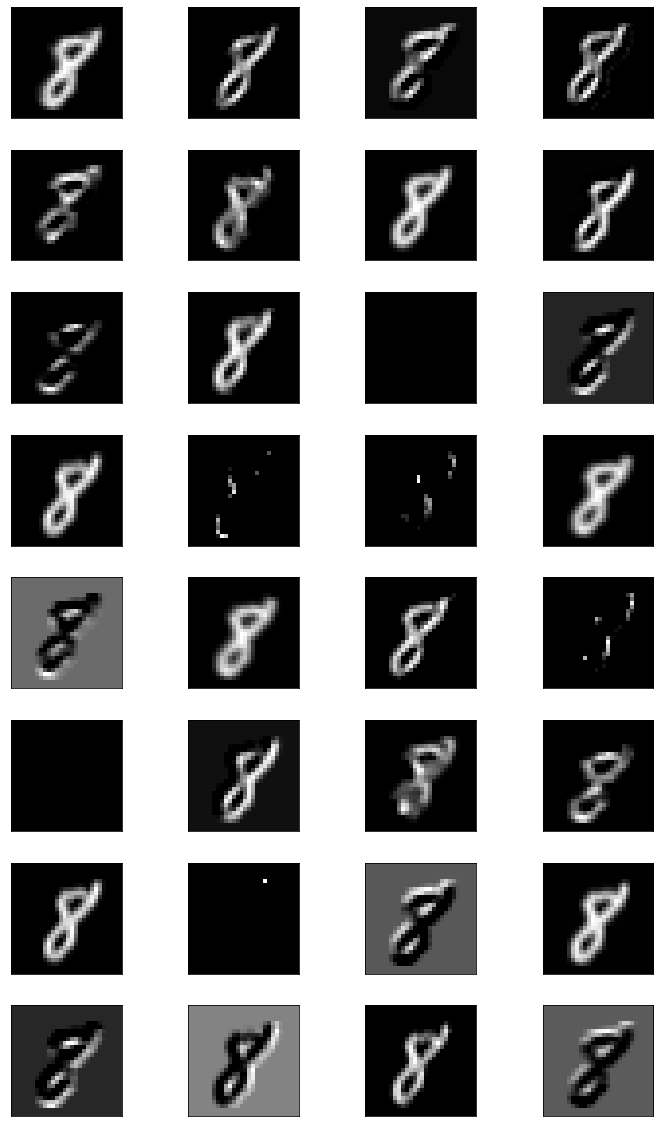

In [253]:
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,16))
fig.tight_layout()

for i in outputs[0]:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter_image=i.detach().numpy()
    plt.imshow(filter_image,cmap='gray')
    ix+=1
plt.show()

Most of the feature maps sort of highlight the edges of the number, indicates that it learns the low-level features like edges here.

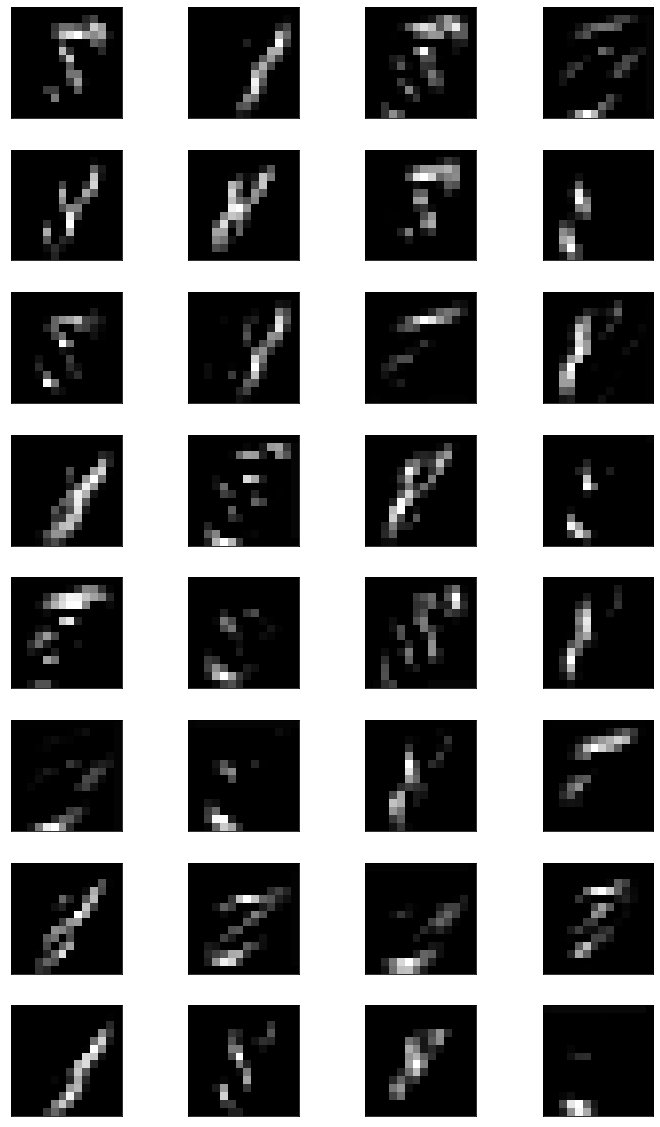

In [255]:
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,16))
fig.tight_layout()

for i in outputs[1]:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter_image=i.detach().numpy()
    plt.imshow(filter_image,cmap='gray')
    ix+=1
plt.show()

The above feature maps are hardly interpretable. Clearly, with depth the feature maps become less interpretable

<h2> Occlusion experiments </h2>

In [63]:
import seaborn as sns

In [64]:
def occlusion_hm(img,label,k=3,oc_val =0.0):
  img = img.to(torch.device('cpu'))
  occ_image = img.detach().clone()
  map = np.zeros((28,28))

  for i in range(28):
    for j in range(28):
      occ_image = img.detach().clone()
      for a in range(max(0,i-int(k/2)),min(27,i+int(k/2)+1)):
        for b in range(max(0,j-int(k/2)),min(27,j+int(k/2)+1)):
          occ_image[0][a][b] = oc_val
      map[i][j] = nn.Softmax(dim=0)(model_loaded(occ_image.reshape((1,1,28,28)).to(device)).to(torch.device('cpu'))[0])[label]

  return map

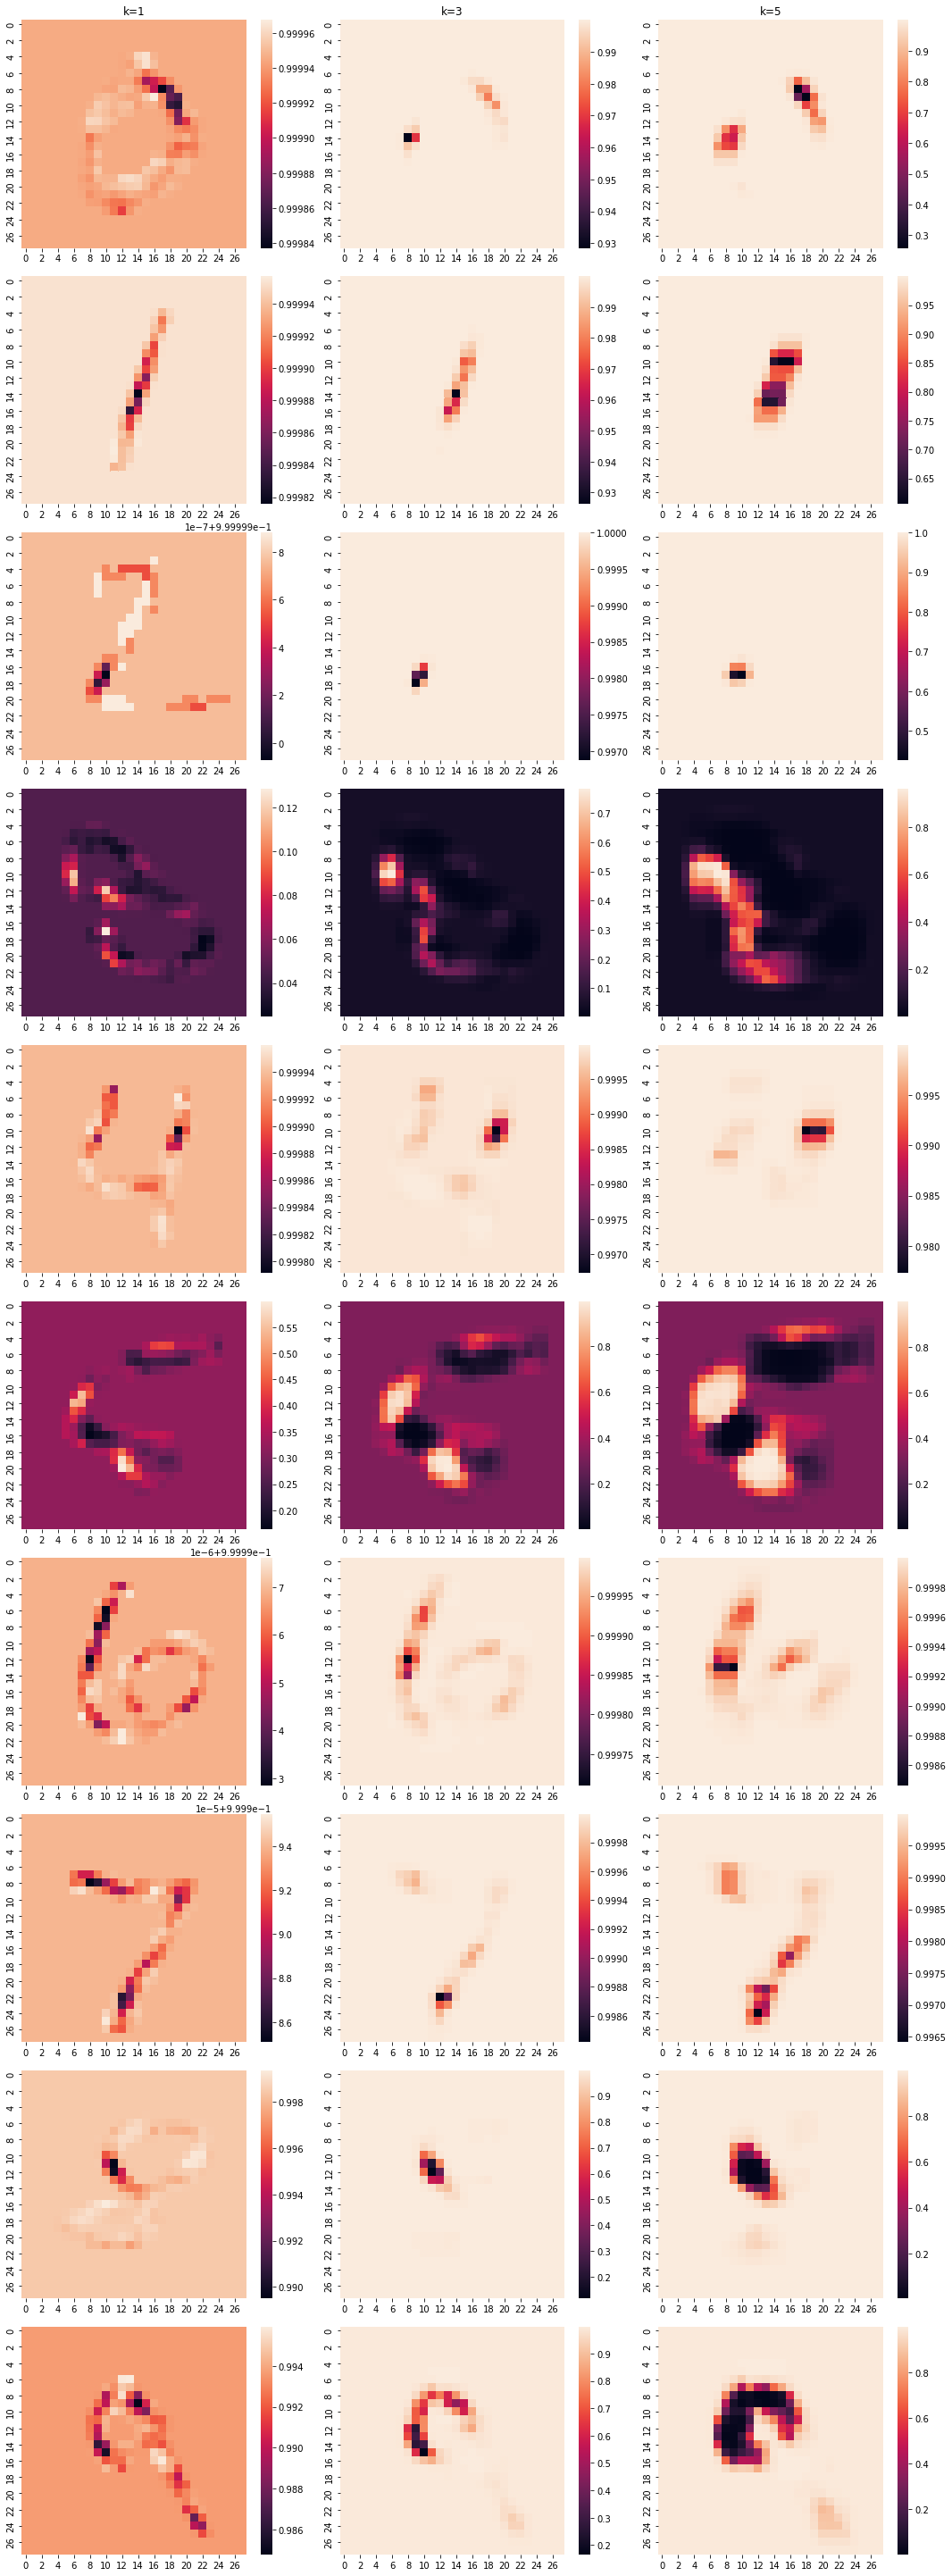

In [74]:
fig, ax = plt.subplots(10, 3, figsize=(15,40))
fig.tight_layout()
for i in range(10):
  img = sample_img(i)
  ax = plt.subplot(10,3,3*i+1)
  if i==0: ax.set_title('k=1')
  sns.heatmap(occlusion_hm(img,i,k=1))
  ax = plt.subplot(10,3,3*i+2)
  if i==0: ax.set_title('k=3')
  sns.heatmap(occlusion_hm(img,i,k=3))
  ax = plt.subplot(10,3,3*i+3)
  if i==0: ax.set_title('k=5')
  sns.heatmap(occlusion_hm(img,i,k=5))  



The above figure shows the heatmap for probability of target class given the center location of the patch, for each example we plot for 3 different patch sizes: 1,3,5. Learning makes sense because the probability falls only while occluding the digit pixels

<h2> Adversarial examples </h2>

Prelude: In the space of all possible images, there will be only some which can sensibly be called as numbers.

What about the rest of the possible images?

Is there something in between which sort of looks like a number??

Finally, can we have an example which looks like a particular number but the network predicts it as something else

In [167]:
def adv_gen1(model,Target_class,mean=0.5,sigma=0.1,epochs=500,plot_cost = False):
  X = torch.normal(mean,sigma,size = (1,1,28,28)).to(device)
  X.requires_grad = True

  optim = torch.optim.SGD([X],lr=1e-2)
  cost_matrix =[]

  for i in range(epochs):
    optim.zero_grad()
    criterion = -model_loaded.forward(X)[0][Target_class]
    cost_matrix.append(-criterion.to(torch.device('cpu')).detach())
    criterion.backward()
    optim.step()

  if plot_cost:
    plt.title('Cost with epochs')
    plt.plot(cost_matrix)
    plt.show()
    
  
  plt.imshow(X[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  confidence  = nn.Softmax(dim=0)(model_loaded(X.to(device)).to(torch.device('cpu'))[0])[Target_class].detach().item()
  #plt.title(f'Predicted label : {model_loaded.forward(X).argmax(1).detach().item()} confidence : {confidence}')
  return model_loaded.forward(X).argmax(1).detach().item(),confidence 

def adv_gen2(model,Target_class,Actual_class,beta =0.001,mean=0.5,sigma=0.1,epochs=500,plot_cost = False):
  X = torch.normal(mean,sigma,size = (1,1,28,28)).to(device)
  X.requires_grad = True

  optim = torch.optim.SGD([X],lr=1e-2)
  cost_matrix =[]
  actual_img = sample_img(Actual_class)
  for i in range(epochs):
    optim.zero_grad()
    criterion = -model_loaded.forward(X)[0][Target_class]+beta*nn.MSELoss()(X[0],actual_img)
    cost_matrix.append(-criterion.to(torch.device('cpu')).detach())
    criterion.backward()
    optim.step()

  if plot_cost:
    plt.plot(cost_matrix)
    plt.show()
  
  plt.imshow(X[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  confidence  = nn.Softmax(dim=0)(model_loaded(X.to(device)).to(torch.device('cpu'))[0])[Target_class].detach().item()
  #plt.title(f'Pred: {model_loaded.forward(X).argmax(1).detach().item()} confidence: {confidence}')
  return model_loaded.forward(X).argmax(1).detach().item(),confidence



<h4> 1.Non-targeted </h4>

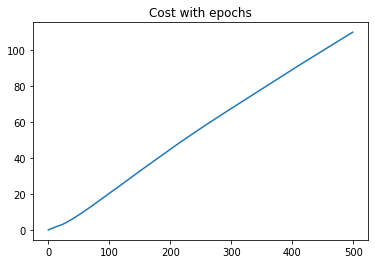

(5, 1.0)

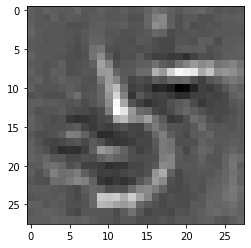

In [121]:
adv_gen1(model_loaded,Target_class=5,plot_cost=True)

Clearly, the cost increases with the epochs

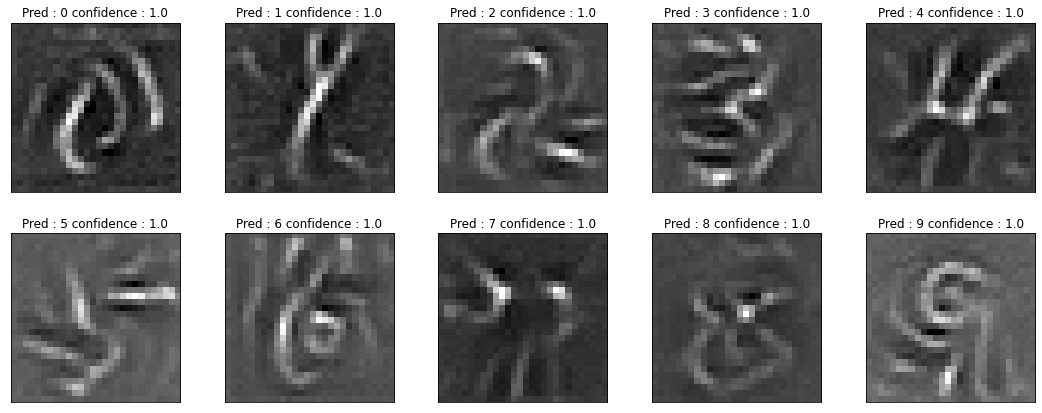

In [115]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))
fig.tight_layout()
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  pred,confidence = adv_gen1(model_loaded,Target_class=i)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Pred : {pred} confidence : {confidence}')

All the above images are classisified with a probability of 1 as the corresponding classes.Some of them have similarity with the predicted images but in no way look like natural hand-written digits

<h4> 2. Targeted </h4>

To the previous cost we add a prior such that it should look as close as possible to target image(2).

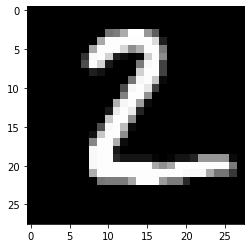

In [132]:
plt.imshow(sample_img(2)[0],cmap='gray')

Target_image

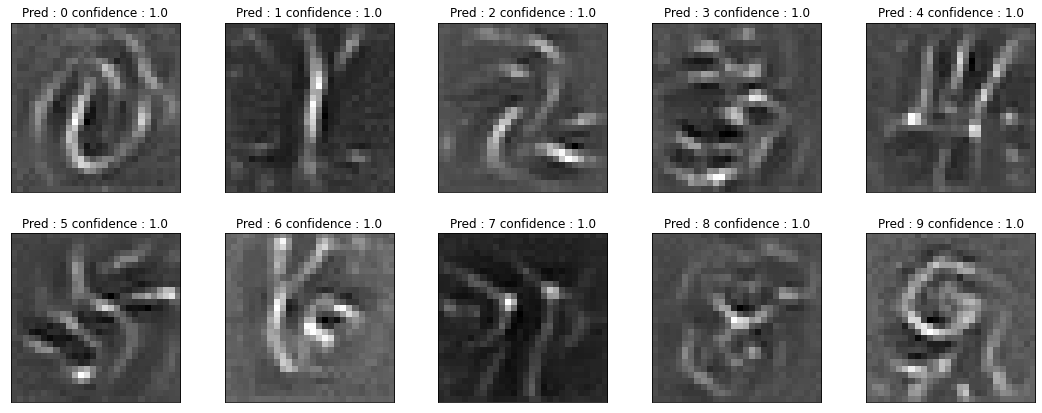

In [141]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))
fig.tight_layout()
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  pred,confidence = adv_gen2(model_loaded,Target_class=i,Actual_class=2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Pred : {pred} confidence : {confidence}')


The above generated examples look more similar to the target_class rather than target_image

<h4> 3. Adding Noise </h4>

In [213]:
def adv_gen3(model,Target_class,Actual_class,beta =1e2,plot_cost = False):
  N = torch.zeros((1,1,28,28)).to(device)
  N.requires_grad = True

  optim = torch.optim.SGD([N],lr=1e-2)
  cost_matrix =[]
  X = sample_img(Actual_class)

  pred_class = 11

  epochs =0 
  while(pred_class!=Target_class):
    optim.zero_grad()
    criterion = -(model_loaded.forward(X+N))[0,Target_class]
    criterion.backward()
    optim.step()
    cost_matrix.append(-criterion.to(torch.device('cpu')).detach())
    pred_class = model_loaded.forward(X+N).argmax(1)
    epochs +=1
  #print(epochs)

  if plot_cost:
    plt.plot(cost_matrix)
    plt.show()
  
  gen = X+N
  plt.imshow(gen[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  pred = model_loaded.forward(X+N).argmax(1).detach().item()
  #plt.title(f'Predicted label : {pred}')
  return pred,X,N,epochs

In [ ]:
adv_gen3(model_loaded,9,2)

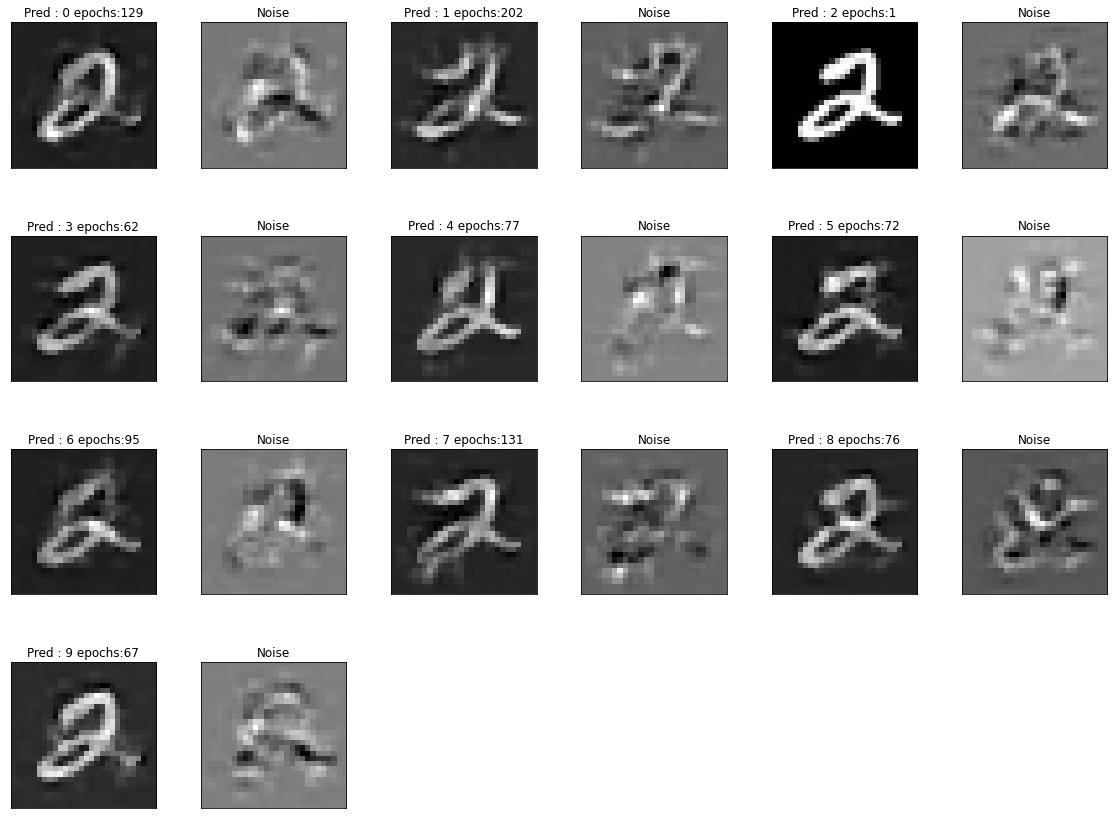

In [238]:
fig, ax = plt.subplots(4, 6, figsize=(16,12))
fig.tight_layout()
for i in range(10):
  ax = plt.subplot(4,6,2*i+1)
  pred,x,noise,epochs = adv_gen3(model_loaded,Target_class=i,Actual_class=2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Pred : {pred} epochs:{epochs}')
  ax = plt.subplot(4,6,2*i+2)
  plt.imshow(noise[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Noise')

for i in range(10,12):
  ax = plt.subplot(4,6,2*i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_axis_off()
 
  ax = plt.subplot(4,6,2*i+2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_axis_off()

plt.show()

Fooled the CNN! Though the examples look like 2 but they are predicted as otherwise

An important observation: The noise images look similar to the previously generated images

We perform the following experiment:

1.For various target images, we observe the noise that gets added to classify it as a fixed target class(in this case 2)

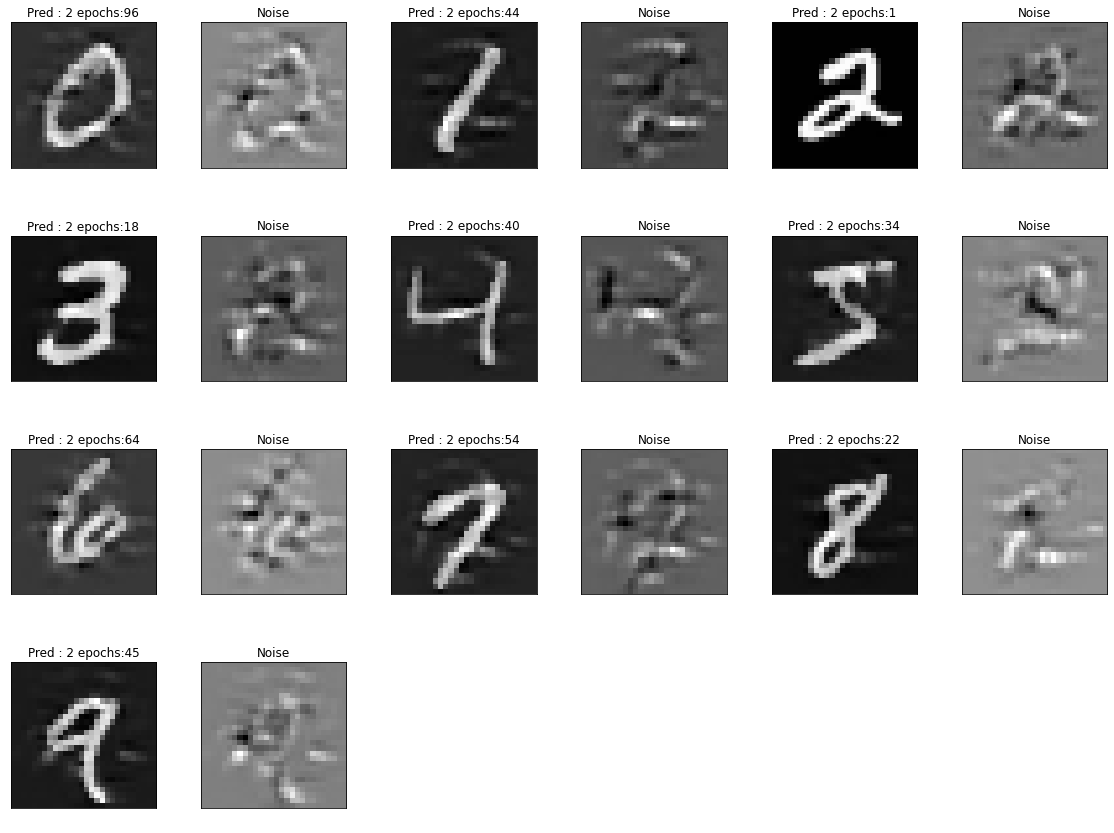

In [214]:
noises = []
inputs = []
fig, ax = plt.subplots(4, 6, figsize=(16,12))
fig.tight_layout()
for i in range(10):
  ax = plt.subplot(4,6,2*i+1)
  pred,x,noise,epochs = adv_gen3(model_loaded,Target_class=2,Actual_class=i)
  noises.append(noise)
  inputs.append(x)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Pred : {pred} epochs:{epochs}')
  ax = plt.subplot(4,6,2*i+2)
  plt.imshow(noise[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Noise')

for i in range(10,12):
  ax = plt.subplot(4,6,2*i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_axis_off()
 
  ax = plt.subplot(4,6,2*i+2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_axis_off()

plt.show()

All the different digits added with the above noise is predicted as 2

Checking if noise for zero works for other examples like 1,2..., i.e. Is the noise transferable across image example?

In [229]:
def noise_general(num):
  fig, ax = plt.subplots(4, 6, figsize=(16,12))
  fig.tight_layout()
  for i in range(10):
    ax = plt.subplot(4,6,2*i+1)
    plt.imshow((inputs[i]+noises[num])[0][0].to(torch.device('cpu')).detach(),cmap='gray')
    pred = model_loaded.forward(inputs[i]+noises[num]).argmax(1).detach().item()
    #plt.title(f'Predicted label : {model_loaded.forward(inputs[i]+noises[num]).argmax(1).detach().item()}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Pred : {pred} ')
    ax = plt.subplot(4,6,2*i+2)
    plt.imshow(noises[num][0][0].to(torch.device('cpu')).detach(),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Noise')

  for i in range(10,12):
    ax = plt.subplot(4,6,2*i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
  
    ax = plt.subplot(4,6,2*i+2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()

  plt.show()

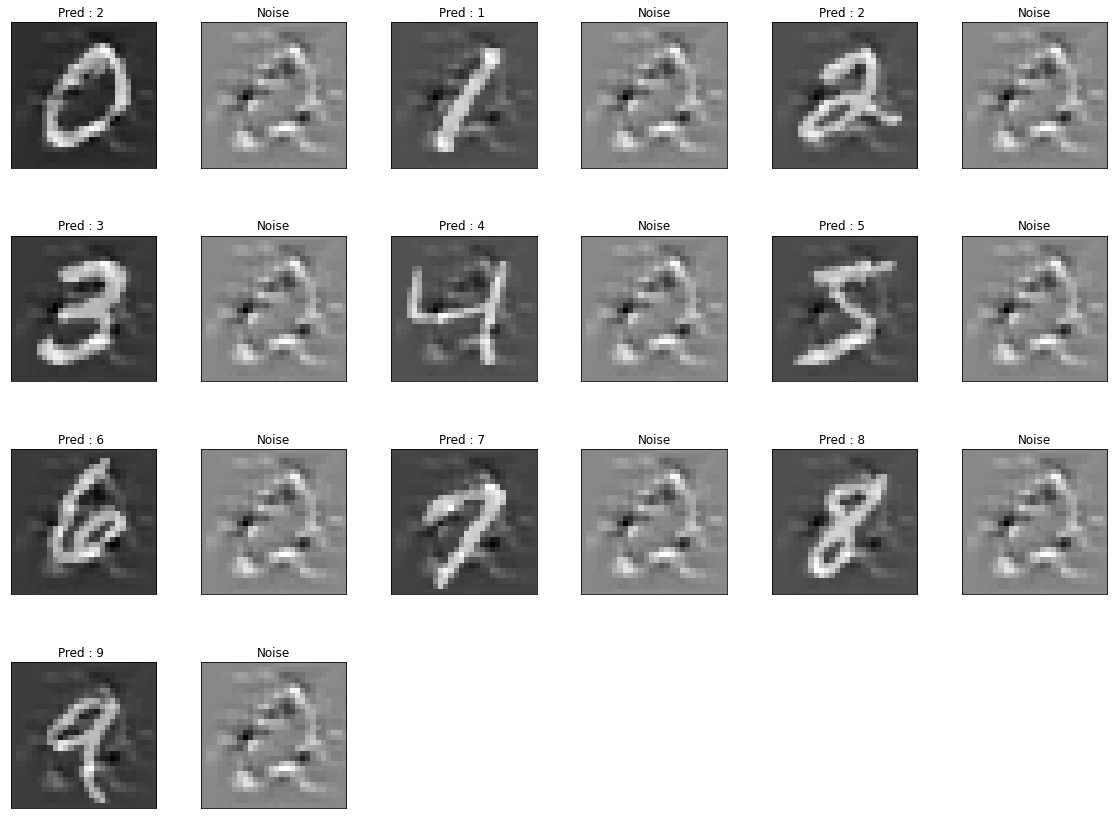

In [230]:
noise_general(0)

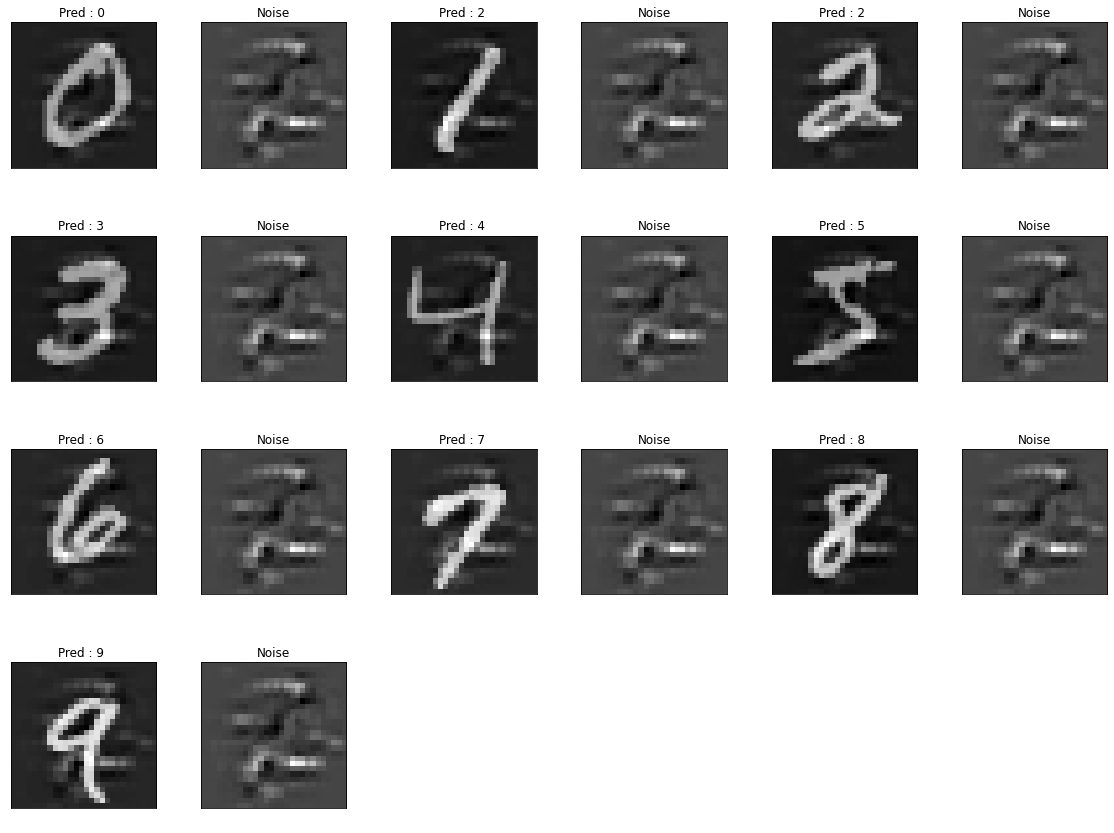

In [231]:
noise_general(1)

The noise is not transferable across examples. We will get similar results as above for noise images of other classes

Clearly, third method seems better in the sense that the adversarial example has more resembelance to target image.

The second method should also ideally work given that we're enforcing a MSE prior.
But still it doesn't seem as effective as the third one.This is the conclusion I've come after trying a range of beta values for which the results didn't change.
So, main question that is posed to us: Is MSE effectively enforcing the prior or some other function of X and target_image be used?

One more additional experiment: What output do we get when we pass the noise images?

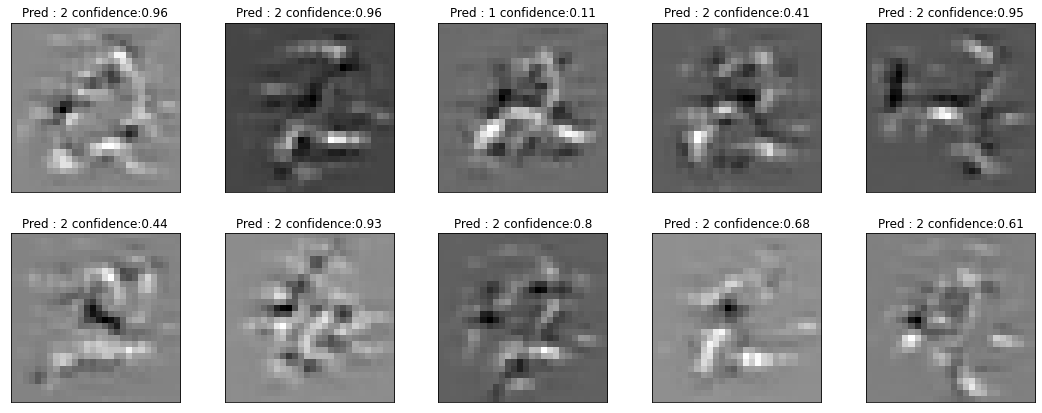

In [262]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))
fig.tight_layout()
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  pred = model_loaded.forward(noises[i]).argmax(1).detach().item()
  confidence = nn.Softmax(dim=0)(model_loaded(noises[i]).to(torch.device('cpu'))[0])[pred].detach().item()
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(noises[i][0][0].to(torch.device('cpu')).detach(),cmap='gray')
  ax.set_title(f'Pred : {pred} confidence:{round(confidence,2)}')


Most of the noise images are predicted as 2 with varying confidence mostly greater than 0.4. Should ignore noise for 2 because it ran only for 1 epoch and is insignificant